In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns

In [3]:
submission_sample = pd.read_csv("data/sample_submission.csv")
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

### exploration

#### task info
+ categorizing shopping trip types based on the items that customers purchased
+ Walmart has categorized the trips contained in this data into 38 distinct types using a proprietary method applied to an extended set of data
+ recreate this categorization/clustering with a more limited set of features

#### data fields
+ TripType - a categorical id representing the type of shopping trip the customer made. This is the ground truth that you are predicting. TripType_999 is an "other" category.
+ VisitNumber - an id corresponding to a single trip by a single customer
+ Weekday - the weekday of the trip
+ Upc - the UPC number of the product purchased
+ ScanCount - the number of the given item that was purchased. A negative value indicates a product return.
+ DepartmentDescription - a high-level description of the item's department
+ FinelineNumber - a more refined category for each of the products, created by Walmart

### train exploration

In [4]:
train.shape

(647054, 7)

In [5]:
test.shape

(653646, 6)

In [6]:
# missing data ?
train.dtypes

TripType                   int64
VisitNumber                int64
Weekday                   object
Upc                      float64
ScanCount                  int64
DepartmentDescription     object
FinelineNumber           float64
dtype: object

In [7]:
train.Weekday.unique()

array(['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday'], dtype=object)

In [8]:
missing_train_ind = pd.isnull(train).any(1).nonzero()[0]
missing_test_ind = pd.isnull(test).any(1).nonzero()[0]

In [9]:
train.loc[missing_train_ind].shape

(4129, 7)

In [10]:
test.loc[missing_test_ind].shape

(3986, 6)

In [11]:
# which columns have missing values
train.loc[missing_train_ind].apply(pd.isnull).apply(any)

TripType                 False
VisitNumber              False
Weekday                  False
Upc                       True
ScanCount                False
DepartmentDescription     True
FinelineNumber            True
dtype: bool

In [12]:
test.loc[missing_test_ind].apply(pd.isnull).apply(any)

VisitNumber              False
Weekday                  False
Upc                       True
ScanCount                False
DepartmentDescription     True
FinelineNumber            True
dtype: bool

+ in both test and train the only missing values are from Upc, DepartmentDescription and FinelineNumber

In [13]:
len(train.Upc.unique())

97715

In [14]:
np.sort(train.ScanCount.unique())

array([-12, -10,  -9,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   1,   2,   3,
         4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
        17,  18,  19,  20,  22,  23,  24,  25,  30,  31,  46,  51,  71])

In [15]:
len(train.FinelineNumber.unique())

5196

In [16]:
len(train.VisitNumber.unique())

95674

In [17]:
# create id
train['id'] = train.index.values
test['id'] = test.index.values

In [19]:
train.head(5)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,id
0,999,5,Friday,68113152929,-1,FINANCIAL SERVICES,1000,0
1,30,7,Friday,60538815980,1,SHOES,8931,1
2,30,7,Friday,7410811099,1,PERSONAL CARE,4504,2
3,26,8,Friday,2238403510,2,PAINT AND ACCESSORIES,3565,3
4,26,8,Friday,2006613744,2,PAINT AND ACCESSORIES,1017,4


In [20]:
test.head(5)

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,id
0,1,Friday,72503389714,1,SHOES,3002,0
1,1,Friday,1707710732,1,DAIRY,1526,1
2,1,Friday,89470001026,1,DAIRY,1431,2
3,1,Friday,88491211470,1,GROCERY DRY GOODS,3555,3
4,2,Friday,2840015224,1,DSD GROCERY,4408,4


In [21]:
submission_sample.head(5)

,VisitNumber,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,...,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


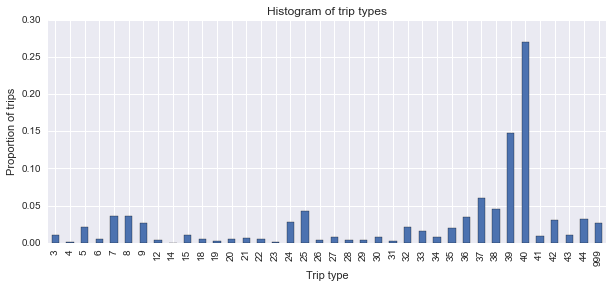

In [22]:
train.TripType.value_counts(normalize=True).sort_index().plot.bar(figsize=(10,4))
plt.title('Histogram of trip types')
plt.ylabel('Proportion of trips')
plt.xlabel('Trip type')
plt.show()

+ unequal proportion of trip types to predict...

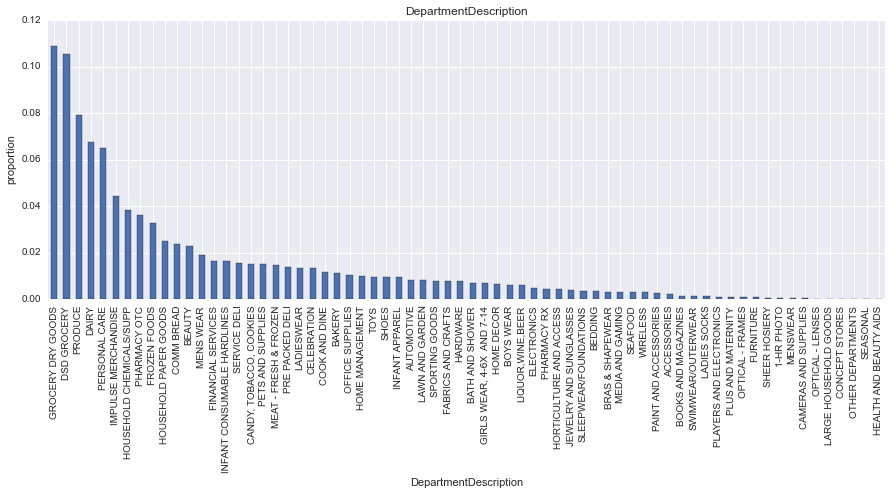

In [23]:
train.DepartmentDescription.value_counts(normalize=True).plot.bar(figsize=(15,5))
plt.title("DepartmentDescription")
plt.ylabel("proportion")
plt.xlabel("DepartmentDescription")

/Users/danielg/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


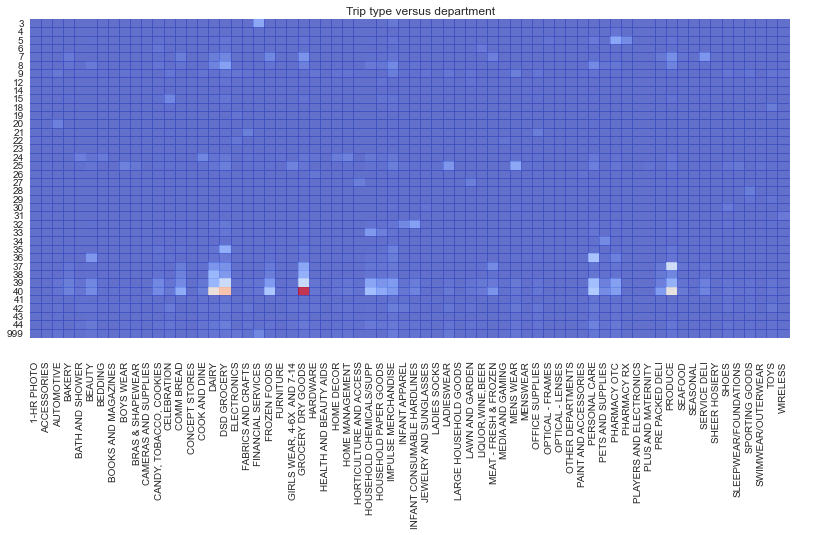

In [24]:
# http://nbviewer.ipython.org/gist/joelotz/5427209

# Plot it out
fig, ax = plt.subplots()
cross_table = pd.crosstab(train.TripType, train.DepartmentDescription)
heatmap = ax.pcolor(cross_table, cmap=plt.cm.coolwarm, alpha=0.8)

fig = plt.gcf()
fig.set_size_inches(14,6)

# turn off the frame
ax.set_frame_on(False)
# put the major ticks at the middle of each cell
ax.set_yticks(np.arange(cross_table.shape[0])+0.5, minor=False)
ax.set_xticks(np.arange(cross_table.shape[1])+0.5, minor=False)
# want a more natural, table-like display
ax.invert_yaxis()
#ax.xaxis.tick_top()
# Set the labels
ax.set_yticklabels(cross_table.index, minor=False) 
ax.set_xticklabels(cross_table.columns, minor=False)
# rotate the 
plt.xticks(rotation=90)
ax.grid(False)
# Turn off all the ticks
ax = plt.gca()
for t in ax.xaxis.get_major_ticks(): 
    t.tick1On = False 
    t.tick2On = False 
for t in ax.yaxis.get_major_ticks(): 
    t.tick1On = False 
    t.tick2On = False  
plt.title("Trip type versus department")
plt.show()

In [25]:
# could create variable with number of items per visit???
# will probably be quite useful??
    # will be able to create other variables like: departmenttype flat, etc - so quite a lot of other variables

unique_trip_items_train = train.groupby(['VisitNumber']).agg({'id': len})
unique_trip_items_train.columns = ['unique_trip_items']

unique_trip_items_test = test.groupby(['VisitNumber']).agg({'id': len})
unique_trip_items_test.columns = ['unique_trip_items']

# also total number by the scancounts...
trip_scancount_total_train = train.groupby(['VisitNumber']).agg({'ScanCount': sum})
trip_scancount_total_train.columns = ['ScanCount_total']

trip_scancount_total_test = test.groupby(['VisitNumber']).agg({'ScanCount': sum})
trip_scancount_total_test.columns = ['ScanCount_total']

In [26]:
print(train.shape)
print(test.shape)

(647054, 8)
(653646, 7)


In [27]:
train = train.merge(unique_trip_items_train, left_on='VisitNumber', right_index=True)
train = train.merge(trip_scancount_total_train, left_on="VisitNumber", right_index=True)

In [28]:
train.shape

(647054, 10)

In [29]:
test = test.merge(unique_trip_items_test, left_on="VisitNumber", right_index=True)
test = test.merge(trip_scancount_total_test, left_on="VisitNumber", right_index=True)

In [30]:
test.shape

(653646, 9)

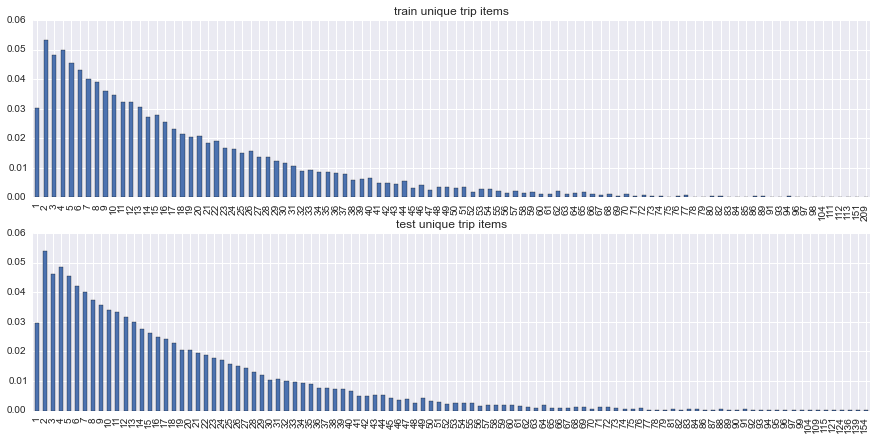

In [31]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(211)
train.unique_trip_items.value_counts(normalize=True).sort_index().plot.bar(title="train unique trip items")
ax = fig.add_subplot(212)
test.unique_trip_items.value_counts(normalize=True).sort_index().plot.bar(title="test unique trip items")

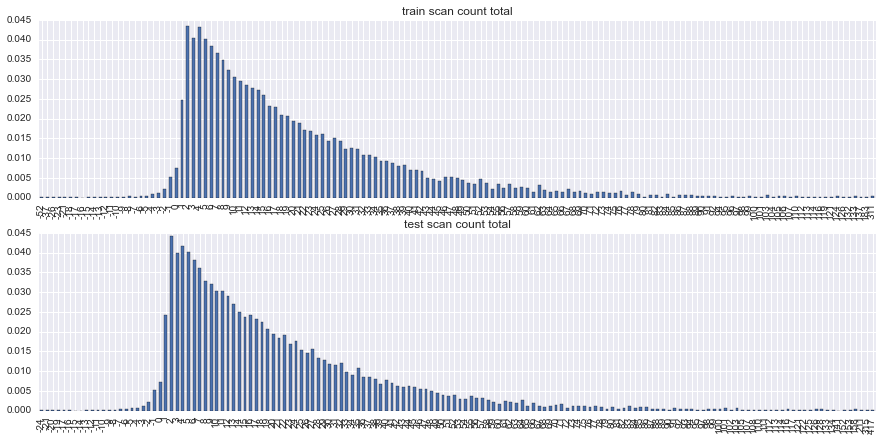

In [32]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(211)
train.ScanCount_total.value_counts(normalize=True).sort_index().plot.bar(title="train scan count total")
ax = fig.add_subplot(212)
test.ScanCount_total.value_counts(normalize=True).sort_index().plot.bar(title="test scan count total")

/Users/danielg/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


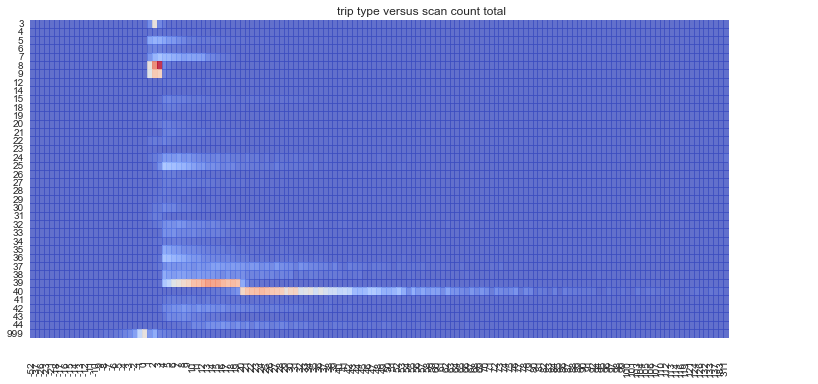

In [33]:
fig, ax = plt.subplots()
triptype_by_scancounttotal = pd.crosstab(train.TripType, train.ScanCount_total)
heatmap = ax.pcolor(triptype_by_scancounttotal, cmap=plt.cm.coolwarm, alpha=0.8)
fig = plt.gcf()
fig.set_size_inches(14,6)

# turn off the frame
ax.set_frame_on(False)
# put the major ticks at the middle of each cell
ax.set_yticks(np.arange(triptype_by_scancounttotal.shape[0])+0.5, minor=False)
ax.set_xticks(np.arange(triptype_by_scancounttotal.shape[1])+0.5, minor=False)
# want a more natural, table-like display
ax.invert_yaxis()
#ax.xaxis.tick_top()
# Set the labels
ax.set_yticklabels(triptype_by_scancounttotal.index, minor=False) 
ax.set_xticklabels(triptype_by_scancounttotal.columns, minor=False)
# rotate the 
plt.xticks(rotation=90)
ax.grid(False)
# Turn off all the ticks
ax = plt.gca()
for t in ax.xaxis.get_major_ticks(): 
    t.tick1On = False 
    t.tick2On = False 
for t in ax.yaxis.get_major_ticks(): 
    t.tick1On = False 
    t.tick2On = False 
plt.title("trip type versus scan count total")

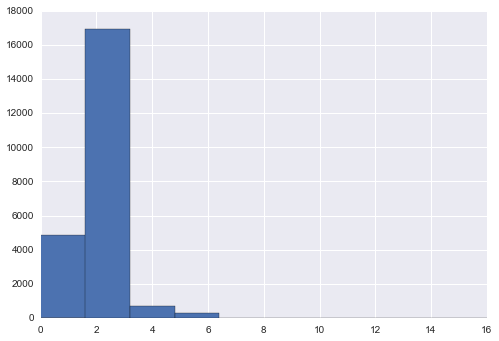

In [34]:
## have a look at some of the more interesting trip types

train[train.TripType == 8].ScanCount_total.hist()